# Image Classification Project
-------------------------------
Please Use GPU Runtime For Faster Training

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports --Alphabetical Order--
from google.colab import files
from keras import layers
from keras import models
from keras import optimizers
from keras.engine import input_layer
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import splitfolders

## Load and Tweak Dataset

### Load Dataset

You will need Kaggle.JSON to use the API in this notebook.

In [4]:
# Must upload kaggle.json to retrieve data
files.upload()

# Removes .kaggle directory if already present
!rm -r ~/.kaggle
# Make .kaggle directory
!mkdir ~/.kaggle
# Move Uploaded kaggle.json to .kaggle directory
!mv ./kaggle.json ~/.kaggle/
# Allows Directory to be Viewable for kaggle command
!chmod 600 ~/.kaggle/kaggle.json

# Download Kaggle Intel Image Classification Data
!kaggle datasets download -d puneet6060/intel-image-classification

# Remove Old Prediction Directory
!rm -r ~/seg_pred
# Remove Original Training and Testing Datasets
!rm -r ~/seg_train
!rm -r ~/seg_test

# Unzip Intel Image Classification
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [5]:
# View zip contents
!ls

intel-image-classification.zip	sample_data  seg_pred  seg_test  seg_train


#### Splitting Training Folder into Training and Validation
~14 Thousand Images and Labels [75:25]

In [6]:
# The path to the directory of original training dataset
orig_train_dir = 'seg_train/seg_train'

# Declare New Directory to hold Training, Validation, and Testing
base_dir = 'intel_image_classify'

# Remove if already there
!rm -r ~/intel_image_classify

# Split Train Directory in to Training and Validation
splitfolders.ratio(orig_train_dir, output=base_dir, seed=1337, ratio=(0.75, 0.25, 0))

train_dir='intel_image_classify/train'
validation_dir='intel_image_classify/val'

rm: cannot remove '/root/intel_image_classify': No such file or directory


Copying files: 14034 files [00:02, 4713.91 files/s]


#### Load Test Folder into Directory
3 Thousand Images and Labels

In [7]:
# The path to the directory of original testing dataset
orig_test_dir = 'seg_test/seg_test'

# Move Testing Dataset to Test Folder in Base Directory
shutil.move(orig_test_dir, base_dir)
shutil.rmtree('intel_image_classify/test/')
os.rename('intel_image_classify/seg_test', 'intel_image_classify/test')

# Rename Directory to Test Directory
test_dir = 'intel_image_classify/test'

In [8]:
!ls

intel-image-classification.zip	sample_data  seg_test
intel_image_classify		seg_pred     seg_train


### Tweak Dataset

Since there are 6 Classes, the class_mode for the the genarators should be categorical. In addition, all pictures are sized to 150 * 150 Pixels

In [9]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 10524 images belonging to 6 classes.
Found 3506 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Create and Fit CNN Model

#### Create Model

In [172]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(784, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 17, 17, 128)     

#### Compile Model

In [173]:
model.compile(
  optimizer=optimizers.RMSprop(1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

#### Fit Model

In [174]:
history = model.fit(
          train_generator,
          steps_per_epoch=100,
          epochs=48,
          validation_data=validation_generator,
          validation_steps=50
          )

Epoch 1/48
100/100 [==============================] - 9s 83ms/step - loss: 1.4186 - accuracy: 0.4206 - val_loss: 1.1736 - val_accuracy: 0.5362
Epoch 2/48
100/100 [==============================] - 8s 77ms/step - loss: 1.1438 - accuracy: 0.5431 - val_loss: 1.0931 - val_accuracy: 0.5650
Epoch 3/48
100/100 [==============================] - 6s 64ms/step - loss: 1.0629 - accuracy: 0.5828 - val_loss: 0.9614 - val_accuracy: 0.6200
Epoch 4/48
100/100 [==============================] - 7s 73ms/step - loss: 0.9950 - accuracy: 0.6219 - val_loss: 0.9200 - val_accuracy: 0.6669
Epoch 5/48
100/100 [==============================] - 6s 64ms/step - loss: 0.9165 - accuracy: 0.6514 - val_loss: 0.8564 - val_accuracy: 0.6913
Epoch 6/48
100/100 [==============================] - 8s 80ms/step - loss: 0.8599 - accuracy: 0.6806 - val_loss: 0.8151 - val_accuracy: 0.6944
Epoch 7/48
100/100 [==============================] - 7s 71ms/step - loss: 0.8371 - accuracy: 0.6862 - val_loss: 0.8091 - val_accuracy: 0.7144

#### View Accuracy

In [175]:
scoreSeg = model.evaluate(test_generator)

94/94 [==============================] - 5s 49ms/step - loss: 0.4761 - accuracy: 0.8410


#### View Plotted Results

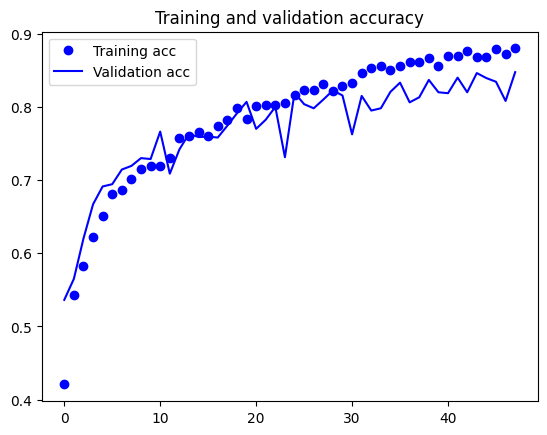

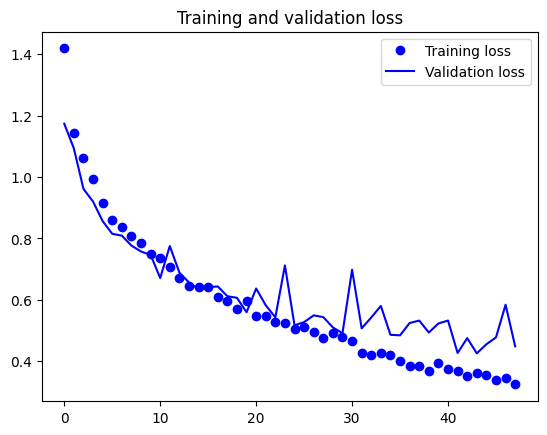

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## View Testing Images
View and Predict 6 Images from Predictions Directory

In [177]:
# List of Picture Files
pre = ['/10004.jpg', '/10034.jpg', '/10048.jpg', '/10013.jpg', '/10043.jpg', '/10021.jpg']
# Path to Predicition Directory
pred_dir='seg_pred/seg_pred'

This Function helps in printing the label with the highest probability from what the model predicted.

In [178]:
# List of Potential Labels
cat = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [179]:

def whatamI(list):
  # Default High Value as First Label
  high = list[0][0]
  hidex=0
  for i in range(6):
    # Stores i and index of i if greater than high
    if high < list[0][i]:
      high = list[0][i]
      hidex = i

  print("Label is %s with %.3f probability" % (cat[hidex], high))
    

#### Image 1

**<font color="green"> Fun Fact! </font>**: During testing it kept thinking this image was a forest, highly likely the tree was the cause of this.

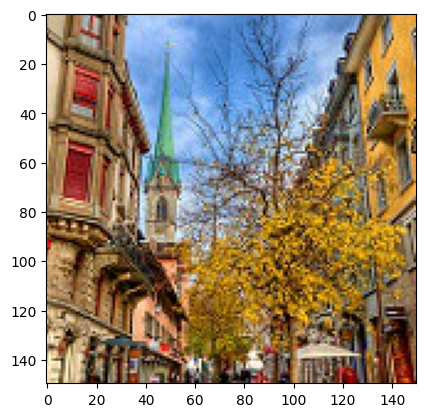

In [180]:
# View image
img_path = pred_dir + pre[0]
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [181]:
# Predict Image
cheese = model.predict(img_tensor)
cheese

1/1 [==============================] - 0s 125ms/step


array([[0.30542716, 0.19983459, 0.00809371, 0.06162164, 0.00576976,
        0.41925317]], dtype=float32)

In [182]:
whatamI(cheese)

Label is street with 0.419 probability


#### Image 2

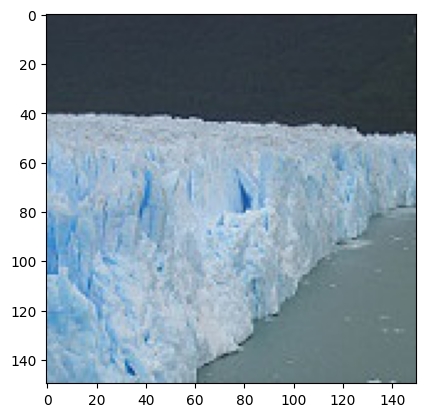

In [183]:
# View image
img_path = pred_dir + pre[1]
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [184]:
# Predict Image
cheese = model.predict(img_tensor)
cheese

1/1 [==============================] - 0s 20ms/step


array([[1.5504372e-04, 5.2318328e-06, 9.8490727e-01, 4.4303224e-03,
        1.0476816e-02, 2.5336469e-05]], dtype=float32)

In [185]:
whatamI(cheese)

Label is glacier with 0.985 probability


#### Image 3

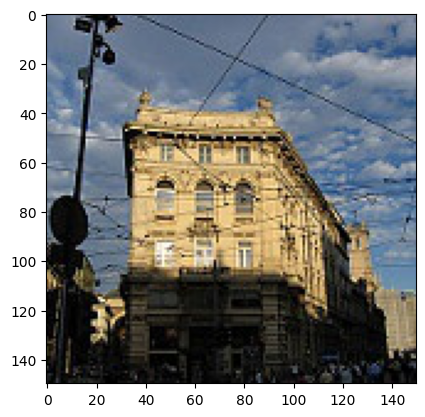

In [186]:
# View image
img_path = pred_dir + pre[2]
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [187]:
# Predict Image
cheese = model.predict(img_tensor)
cheese

1/1 [==============================] - 0s 20ms/step


array([[9.9084365e-01, 2.4003869e-04, 1.1844886e-03, 3.9841793e-04,
        3.9955336e-03, 3.3379300e-03]], dtype=float32)

In [188]:
whatamI(cheese)

Label is buildings with 0.991 probability


#### Image 4

**<font color="green"> Fun Fact! </font>**: For this Image, during early and mid testing it was torn between a glacier and a mountain.

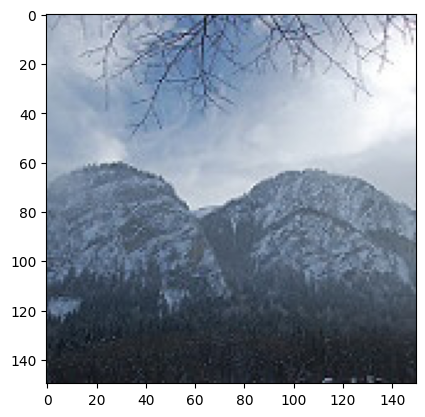

In [189]:
# View image
img_path = pred_dir + pre[3]
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [190]:
# Predict Image
cheese = model.predict(img_tensor)
cheese

1/1 [==============================] - 0s 20ms/step


array([[8.2607631e-04, 1.1375092e-03, 4.0772572e-02, 9.5667154e-01,
        4.8567526e-04, 1.0657409e-04]], dtype=float32)

In [191]:
whatamI(cheese)

Label is mountain with 0.957 probability


#### Image 5

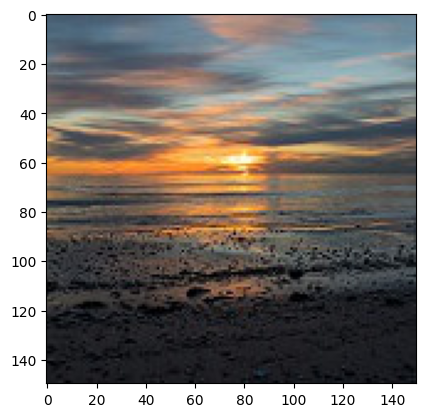

In [192]:
# View image
img_path = pred_dir + pre[4]
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [193]:
# Predict Image
cheese = model.predict(img_tensor)
cheese

1/1 [==============================] - 0s 27ms/step


array([[5.7383586e-05, 1.1858881e-05, 1.6005828e-04, 3.1070556e-03,
        9.9658930e-01, 7.4390649e-05]], dtype=float32)

In [194]:
whatamI(cheese)

Label is sea with 0.997 probability


#### Image 6

**<font color="green"> Fun Fact! </font>**: For this Image, it has always given a 0.999 to 1.000 forest probability throughout testing.

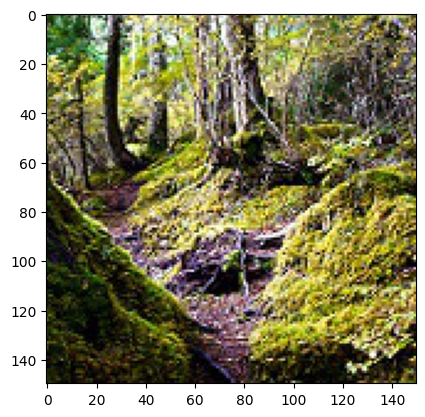

In [195]:
# View image
img_path = pred_dir + pre[5]
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [196]:
# Predict Image
cheese = model.predict(img_tensor)
cheese

1/1 [==============================] - 0s 42ms/step


array([[6.6589084e-05, 9.9877840e-01, 8.3152787e-04, 2.2544187e-04,
        6.4235544e-05, 3.3815166e-05]], dtype=float32)

In [197]:
whatamI(cheese)

Label is forest with 0.999 probability
